In [1]:
import pandas as pd
import seaborn as sns
from collections import Counter
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Чтение сырых данных
На данный момент вся информация с парсеров храниться с csv, однако, в дальнейшем планируется в качестве хранилища использовать PostgerSQL

In [2]:
data = pd.read_csv(
    "data/hvac.csv",
    sep=":::",
    header=None,
    names=["Position", "Salary","Skills", "Body"],
    engine='python',
    encoding='utf-8'
)

data = data.append(pd.read_csv(
    "data/hh_1.csv", sep=":::",
    header=None,
    names=["Position", "Salary","Skills", "Body"],
    engine='python',
    encoding='utf-8'
), ignore_index=True)

data = data.append(pd.read_csv(
    "data/hh_2.csv",
    sep=":::",
    header=None,
    names=["Position", "Salary","Skills", "Body"],
    engine='python',
    encoding='utf-8'
), ignore_index=True)

In [3]:
data.head()

,Position,Salary,Skills,Body
0,"""Senior Java/Kotlin разработчик",от 180 000 до 450 000 руб. до вычета налогов,"Java,NoSQL,Multithread Programming,MySQL,Sprin...",TelQ - международный немецкий поставщик услуг ...
1,"""Программист микроконтроллеров и ПЛИС, С++, Ve...",от 80 000 до 150 000 руб. до вычета налогов,"C/C++,Git,Qt,ООП,STM32,Схемотехника электронно...",Требуется программист C++ для работы с микроко...
2,""".NET C# WinForms Senior Oracle developer",от 250 000 руб. на руки,"ORACLE,C#,.NET Framework,Oracle Pl/SQL,Windows...",На full-time требуется senior C# developer inh...
3,"""Программист 1С",от 150 000 до 180 000 руб. на руки,"ORACLE,C#,.NET Framework,Oracle Pl/SQL,Windows...",Обязанности: АВТОМАТИЗАЦИЯ ОБЩЕКЛИЕНТСКОЙ ИНФ...
4,"""Программист TypeScript, JS",от 120 000 до 170 000 руб. на руки,"ORACLE,C#,.NET Framework,Oracle Pl/SQL,Windows...","Full-stack разработчик (TypeScript, JS)ООО Мас..."


# Первичная очистка данных и аналитика
Очистка:
* привести заработную плату к числовому виду
* провести очистку строк скиллов

Необходимо выделить:
* группы профессий
* количество уникальных скиллов
* соотноешие скиллов с прелагаемой зарабатной платой

При указании вилки заработной платы - выбирается меньшее число. Отбрасываем строки без указания заработной платы. Необходимо учитывать, что некоторые зп - в иностранной валюте, приведены к рублям.

In [4]:
data["Money_type"] = None
data.loc[data["Salary"].str.contains("EUR"), "Money_type"] = "EUR"
data.loc[data["Salary"].str.contains("EUR"), "Money_type"] = "USD"

data["Salary"] = data["Salary"].str.replace(u'\xa0', "")
data_for_clustering = data.copy()
data.drop(index=data[data["Salary"] == "з/п не указана"].index, inplace=True)
data["Salary"] = data["Salary"].apply(lambda row: [int(s) for s in row.split() if s.isdigit()][0])

data.loc[data["Money_type"] == "EUR", "Salary"] = data.loc[data["Money_type"] == "EUR", "Salary"] * 87
data.loc[data["Money_type"] == "USD", "Salary"] = data.loc[data["Money_type"] == "USD", "Salary"] * 71

Распределение зп

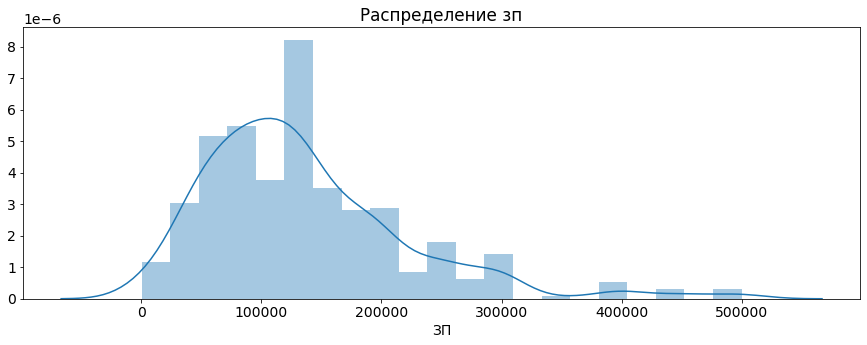

In [5]:
plt.rcParams.update({"font.size":14})
fig, ax = plt.subplots(1, figsize=(15,5))
sns.distplot(data["Salary"], ax=ax)
ax.set_xlabel("ЗП")
ax.set_title("Распределение зп")
plt.show()

Получение набора уникальных скиллов

In [6]:
data["Skills"] = data["Skills"].str.replace(u'\xa0', "")
temp = data["Skills"].to_list()
list_of_skills = []
for i in temp:
    list_of_skills.extend(i.split(","))
del temp

unique_skills = set(list_of_skills)
counted_skills = Counter(list_of_skills)

In [7]:
print(f"Всего скиллов: {len(list_of_skills)}, уникальных: {len(unique_skills)}")

Всего скиллов: 3381, уникальных: 671


In [8]:
names = [x[0] for x in counted_skills.most_common(20)]
values = [x[1] for x in counted_skills.most_common(20)]

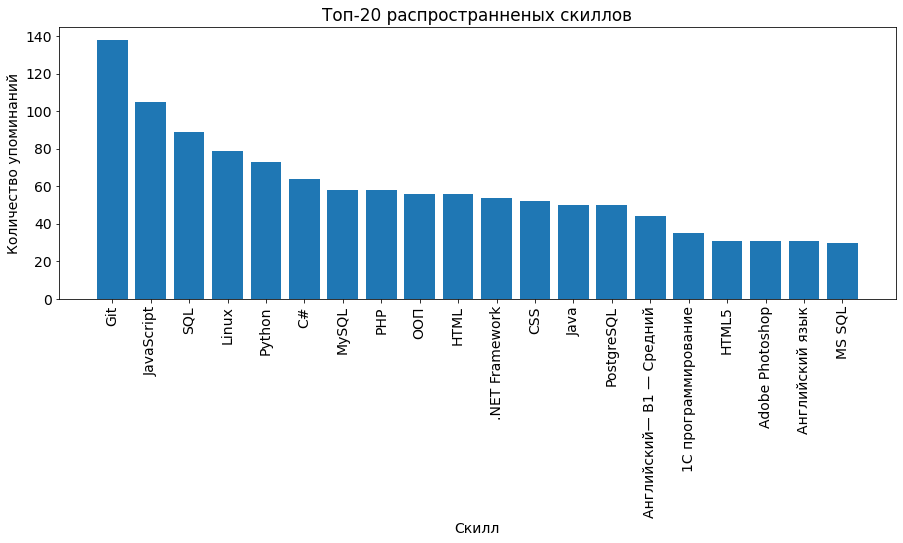

In [9]:
plt.rcParams.update({"font.size":14})
fig, ax = plt.subplots(1, figsize=(15,5))
plt.bar(names, values)
plt.xlabel("Скилл")
plt.ylabel("Количество упоминаний")
plt.title("Топ-20 распространненых скиллов")
plt.xticks(rotation=90)
plt.show()

In [10]:
names = [x[0] for x in counted_skills.most_common()[:-10:-1]]
values = [x[1] for x in counted_skills.most_common()[:-10:-1]]

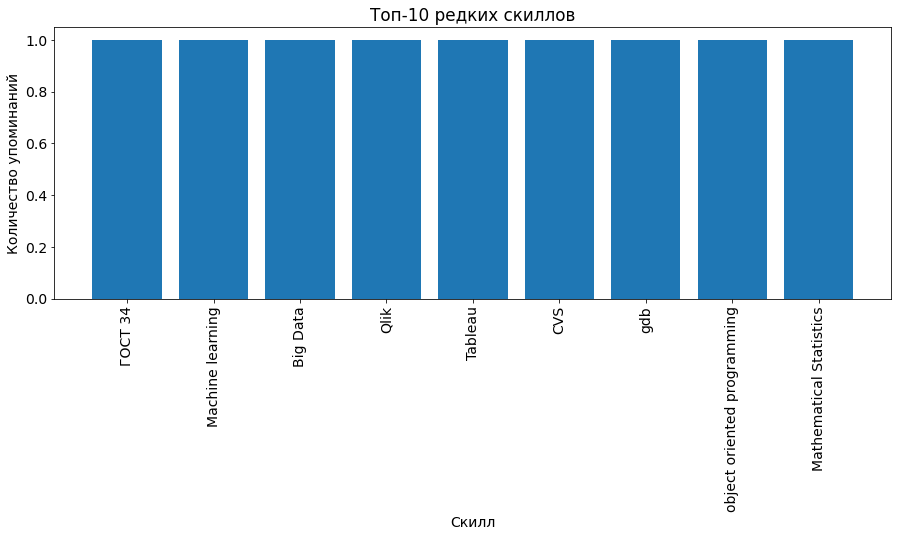

In [11]:
plt.rcParams.update({"font.size":14})
fig, ax = plt.subplots(1, figsize=(15,5))
plt.bar(names, values)
plt.xlabel("Скилл")
plt.ylabel("Количество упоминаний")
plt.title("Топ-10 редких скиллов")
plt.xticks(rotation=90)
plt.show()

Соотнесение скиллов с предлагаемой зарплатой

In [12]:
def skills_to_salary(data:pd.DataFrame, min_salary:int, max_salary:int, top:int) -> None:
    list_of_skills = []
    temp = data[(data["Salary"] > min_salary) & (data["Salary"] <= max_salary)]["Skills"].to_list() 
    for i in temp:
        list_of_skills.extend(i.split(","))
    del temp
    counted_skills = Counter(list_of_skills)
    names = [x[0] for x in counted_skills.most_common(top)]
    values = [x[1] for x in counted_skills.most_common(top)]
    plt.rcParams.update({"font.size":14})
    fig, ax = plt.subplots(1, figsize=(15,5))
    plt.bar(names, values)
    plt.xlabel("Скилл")
    plt.ylabel("Количество упоминаний")
    plt.title("Топ-10 распространненых скиллов в категории {}-{} тыс. рублей".format(min_salary // 1000, max_salary // 1000))
    plt.xticks(rotation=90)
    plt.show()

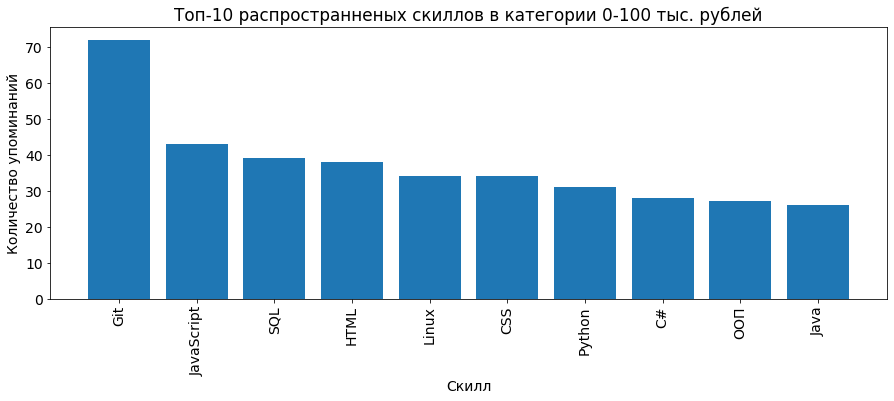

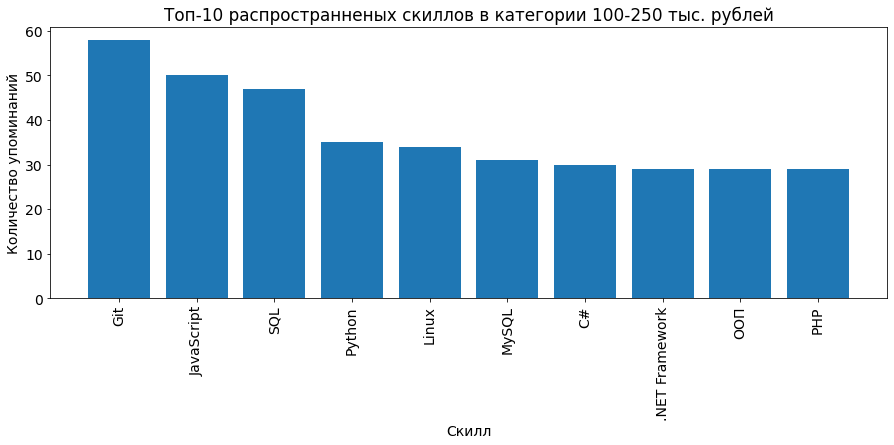

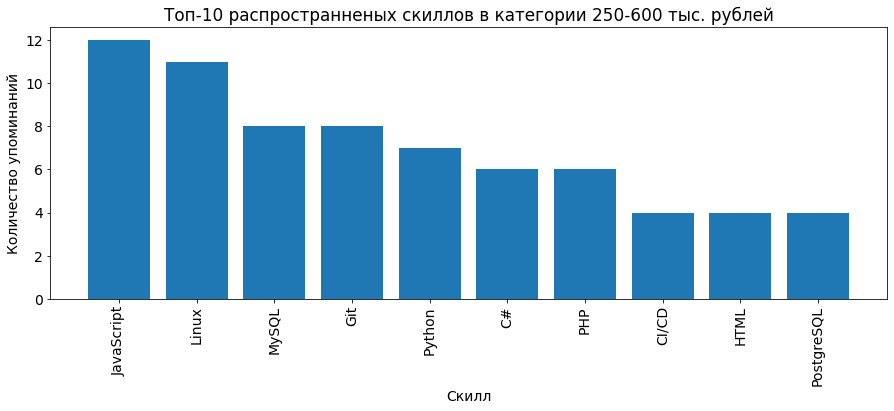

In [13]:
skills_to_salary(data, 0, 100000, 10)
skills_to_salary(data, 100000, 250000, 10)
skills_to_salary(data, 250000, 600000, 10)

# Кластеризация для выявления связанных скиллов
* One-hot encoding
* Кластеризация
* Понижение размерности
* Визуализация

In [14]:
data_for_clustering["Skills"] = data_for_clustering["Skills"].str.replace(u'\xa0', "")
temp = data_for_clustering["Skills"].to_list()
list_of_skills = []
for i in temp:
    list_of_skills.extend(i.split(","))
del temp

unique_skills = set(list_of_skills)
counted_skills = Counter(list_of_skills)

In [15]:
print("Всего позиций (с учетом позиций \'з/п не указана\'): {}".format(len(data_for_clustering)))

Всего позиций (с учетом позиций 'з/п не указана'): 1187


In [16]:
unique_map = {}
for ix, i in enumerate(unique_skills):
    unique_map[i] = ix

In [17]:
vectors = np.zeros(shape=(len(data_for_clustering), len(unique_skills)), dtype=np.float16)
for idx in range(len(data_for_clustering)):
    for j in data_for_clustering.iloc[idx, 2].split(","):
        vectors[idx, unique_map[j]] = 1

In [18]:
print(f"Получено векторов: {vectors.shape[0]}, количество элементов вектора: {vectors.shape[1]}")

Получено векторов: 1187, количество элементов вектора: 946


Кластеризация

In [19]:
import scipy.cluster.hierarchy as hcluster

In [20]:
thresh = 3.5
clusters = hcluster.fclusterdata(vectors, thresh, criterion="distance")

In [21]:
print("Получено кластеров: {}, порог: {} [подобран]".format(len(set(clusters)), thresh))

Получено кластеров: 12, порог: 3.5 [подобран]


Понижение размерности для отрисовки на двумерной плоскости

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(n_components=2, svd_solver='full')
pca.fit(vectors.T)

PCA(n_components=2, svd_solver='full')

Визуализация

In [24]:
colors_map = {10: "red", 9: "green", 4: "blue"}
colors = []
for i in clusters:
    if i in [10,9,4]:
        colors.append(colors_map[i])
    else:
        colors.append("black")

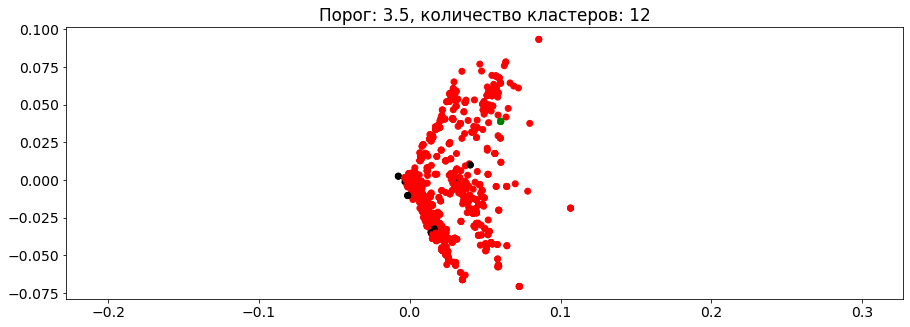

In [25]:
plt.rcParams.update({"font.size":14})
fig, ax = plt.subplots(1, figsize=(15,5))
plt.scatter([x[0] for x in pca.components_.T], [x[1] for x in pca.components_.T], c=colors)
plt.title("Порог: {:.1f}, количество кластеров: {:d}".format(thresh, len(set(clusters))))
plt.axis("equal")
plt.show()

Данные не поддаются кластеризации - это доказывает, что парсинг был консистентен (выбрано одно направление в IT). Также стоит обратить внимание, что сущесетвует основной кластер - более 98% точек и выбросы на оставшиеся 6 кластеров (особенности работы алгоритма).

# Связанность скиллов (визуализация)

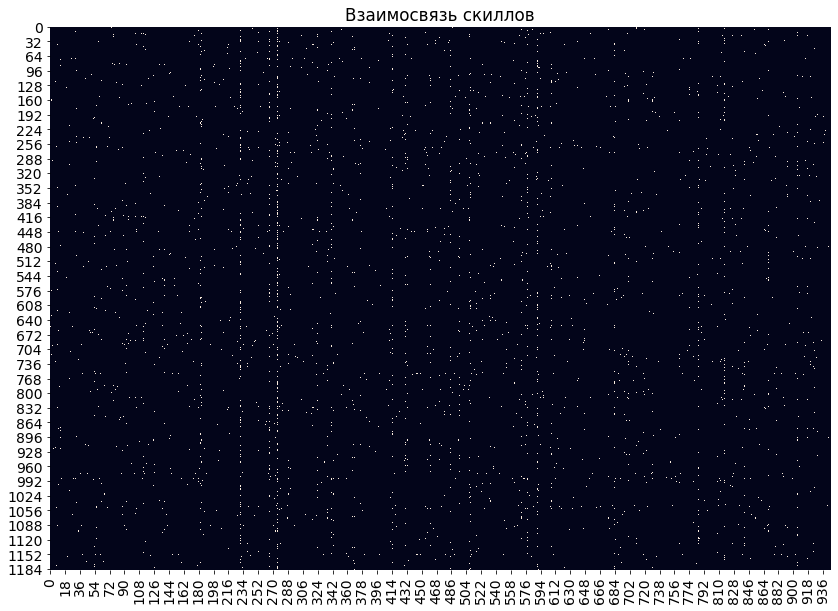

In [26]:
plt.rcParams.update({"font.size":14})
fig, ax = plt.subplots(1, figsize=(14,10))
sns.heatmap(vectors, ax=ax, cbar=None)
ax.set_title("Взаимосвязь скиллов")
plt.show()

Из графика видно, что есть сильные доминанты (вертикальные "линии"), они были обсуждены в разделе "наиболее частые скиллы".

In [27]:
vectors_df = pd.DataFrame(vectors)
vectors_df.head()

,0,1,2,3,4,5,6,7,8,9,...,936,937,938,939,940,941,942,943,944,945
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Проанализируем топ-20 самых популярных скиллов и как они связаны между собой

In [28]:
temp = vectors_df.sum()
skill_to_link = []
for x in range(len(temp)):
    if temp[x] > 65:
        skill_to_link.append(x)
del temp

In [29]:
reverse_unique_map = {}
for key in unique_map.keys():
    reverse_unique_map[unique_map[key]] = key

In [30]:
def relative_connection(raw:pd.DataFrame, ix:int) -> list:
    temp = raw[raw[ix] == 1].sum()
    temp = pd.DataFrame(temp[temp > 0], columns=[reverse_unique_map[ix]]).nlargest(5, reverse_unique_map[ix])
    temp = pd.DataFrame(temp)
    base_len = temp.iloc[0, 0]
    temp = temp.drop(index=ix)
    temp["Skill"] = None
    temp["Percentage"] = None
    for i in range(len(temp)):
        temp.iloc[i, 2] = round(temp.iloc[i, 0] / base_len * 100, 1)
        temp.iloc[i, 1] = reverse_unique_map[temp.index[i]]
    
    return (temp[reverse_unique_map[ix]].sum(), temp)

In [31]:
linked_result = []
max_value = 0
max_idx = 0
for idx, i in enumerate(skill_to_link):
    a, b = relative_connection(vectors_df, i)
    if a > max_value:
        max_value = a
        max_idx = idx
    linked_result.append((a, b))

In [32]:
print("Наиболее частая \'связка скиллов\':")
print(linked_result[max_idx][1])

Наиболее частая 'связка скиллов':
       Git       Skill Percentage
888  104.0  JavaScript       33.1
231   69.0         SQL         22
266   64.0       Linux       20.4
591   59.0      Python       18.8


### Все связки скиллов

In [33]:
for i in linked_result:
    print("Вес:", i[0])
    print(i[1], "\n")

Вес: 178.0
      CSS            Skill Percentage
888  61.0       JavaScript       68.6
415  57.0             HTML       64.1
276  42.0              Git       47.2
608  18.0  Adobe Photoshop       20.2 

Вес: 79.0
     Английский язык                                Skill Percentage
231             28.0                                  SQL       38.4
591             22.0                               Python       30.1
276             15.0                                  Git       20.5
433             14.0  Английский— B2 — Средне-продвинутый       19.2 

Вес: 215.0
      SQL       Skill Percentage
276  69.0         Git       31.6
591  63.0      Python       28.9
571  46.0      MS SQL       21.1
786  37.0  PostgreSQL         17 

Вес: 190.0
     Linux       Skill Percentage
591   65.0      Python       41.9
276   64.0         Git       41.3
786   32.0  PostgreSQL       20.6
231   29.0         SQL       18.7 

Вес: 296.0
       Git       Skill Percentage
888  104.0  JavaScript       33.1


In [35]:
query = "CSS"

In [54]:
for i in linked_result:
    print(i[1].columns[0], i[1][i[1]["Percentage"] == i[1]["Percentage"].max()]["Skill"].values[0])

CSS JavaScript
Английский язык SQL
SQL Git
Linux Python
Git JavaScript
MySQL PHP
HTML JavaScript
HTML5 JavaScript
C++ Git
Английский— B1 — Средний JavaScript
MS SQL SQL
PHP MySQL
Python Linux
Adobe Photoshop Adobe Illustrator
ООП Git
PostgreSQL Git
C# .NET Framework
Java SQL
.NET Framework C#
JavaScript Git
